In [5]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']

In [6]:
#cerco chi sono gli utenti che hanno votato di più
df= pd.DataFrame( db.ratings.aggregate([{'$group': {'_id': '$userId','total': {'$sum': 1}}},{'$sort':{'total': -1}},{'$limit': 3}
]))
df.head()

,_id,total
0,45811,18276
1,8659,9279
2,270123,7638


In [7]:
#una volta trovati prelevo le loro votazioni dalla collezione rating
df_ratings = pd.DataFrame(db.ratings.find({"$or": [{'userId':45811},{'userId':8659},{'userId':270123}]}))
df_ratings.head()


,_id,userId,movieId,rating,timestamp
0,5f662fdf1d75e6a75f7b4119,8659,1,4.0,997044423
1,5f662fdf1d75e6a75f7b411a,8659,2,4.0,997144402
2,5f662fdf1d75e6a75f7b411b,8659,3,3.0,997144734
3,5f662fdf1d75e6a75f7b411c,8659,4,3.0,997146175
4,5f662fdf1d75e6a75f7b411d,8659,5,3.0,997145617


In [8]:
df_ratings.userId.value_counts()

45811     18276
8659       9279
270123     7638
Name: userId, dtype: int64

In [9]:
#elimino colonna _id
df_ratings.drop("_id",axis='columns', inplace=True)
df_ratings.sample(5)

,userId,movieId,rating,timestamp
35121,270123,158966,3.0,1488502097
9425,45811,273,2.5,1482765860
26309,45811,164901,3.5,1490799897
22262,45811,127150,4.0,1455251738
31104,270123,8751,2.0,1436135359


In [10]:
#lista dei film, nella collezione metadata
df_film = pd.DataFrame(db.metadata.find({}, {'_id':1, 'genres':1}))
df_film

,_id,genres
0,862,"[16, 35, 10751]"
1,8844,"[12, 14, 10751]"
2,15602,"[10749, 35]"
3,31357,"[35, 18, 10749]"
4,11862,[35]
...,...,...
45428,439050,"[18, 10751]"
45429,111109,[18]
45430,67758,"[28, 18, 53]"
45431,227506,[]


In [11]:
#rinomino la colonna _id in movie_id
df_film =  df_film.rename(columns = {'_id' : 'movieId'})

In [12]:
#converto i vari id del dataframe da oggetti a int
df_film.movieId = df_film.movieId.astype(str).astype(int)

In [13]:
#utilizzo funzione explode, per creare nuove righe dagli elementi dell' array presenti nella colonna genres
df_film = df_film.explode('genres')
df_film.explode('genres')
df_film = df_film.drop_duplicates(subset ="movieId") 
  


In [14]:
df_film.head()

,movieId,genres
0,862,16
1,8844,12
2,15602,10749
3,31357,35
4,11862,35


In [15]:
#vedo quanti na ci sono 
df_film.isna().sum()

movieId       0
genres     2442
dtype: int64

In [16]:
#prendo solo le righe dove non ci sono na
df_film = df_film[df_film['genres'].notna()]


In [17]:
#check per controllare se ci sono ancora na
df_film.isna().sum()

movieId    0
genres     0
dtype: int64

In [18]:
df_film.shape

(42991, 2)

In [19]:
#prendo i generi nella collezione genres
df_genres = pd.DataFrame(db.genres.find({}))
df_genres.head()

,_id,name
0,16,Animation
1,35,Comedy
2,10751,Family
3,12,Adventure
4,14,Fantasy


In [20]:
#rinomino la colonna _id in movie_id
df_genres =  df_genres.rename(columns = {'_id' : 'genres'})

In [21]:
df_genres.head(2)

,genres,name
0,16,Animation
1,35,Comedy


In [22]:
#join con il dataframe contenente i vari id dei film
df_merge = pd.merge(df_genres, df_film, on='genres')
df_merge.head(2)

,genres,name,movieId
0,16,Animation,862
1,16,Animation,22586


In [23]:
df_merge.shape

(42991, 3)

In [24]:
#join con il dataframe contenente i 5 utenti scelti dalla collezione ratings
df_secondmerge = pd.merge(df_ratings, df_merge, on='movieId')
df_secondmerge

,userId,movieId,rating,timestamp,genres,name
0,8659,2,4.0,997144402,18,Drama
1,45811,2,3.0,1473241811,18,Drama
2,270123,2,1.5,1436135389,18,Drama
3,8659,3,3.0,997144734,18,Drama
4,270123,3,3.0,1436135323,18,Drama
...,...,...,...,...,...,...
8459,270123,145162,1.0,1498259026,80,Crime
8460,270123,147726,3.0,1477535522,18,Drama
8461,270123,151509,3.0,1453527817,35,Comedy
8462,270123,159109,1.5,1465361347,35,Comedy


In [25]:
#vediamo i dati di un singolo utente
df_H1=df_secondmerge[df_secondmerge['userId'] == 8659]
df_H1.head(5)

,userId,movieId,rating,timestamp,genres,name
0,8659,2,4.0,997144402,18,Drama
3,8659,3,3.0,997144734,18,Drama
5,8659,5,3.0,997145617,80,Crime
7,8659,6,4.0,997047595,28,Action
10,8659,11,3.0,997036084,12,Adventure


In [26]:
#raggruppiamo sul genere per vedere la votazione media data ad ogni genere da questo utente
df_meanH1 = df_H1.groupby("name").agg({'rating':'mean'})
df_meanH1.reset_index(inplace=True)
df_meanH1.head(10)

,name,rating
0,Action,3.310881
1,Adventure,3.378531
2,Animation,3.380000
3,Comedy,3.309689
4,Crime,3.286982
5,Documentary,3.302326
6,Drama,3.321782
7,Family,3.450000
8,Fantasy,3.300000
9,Foreign,3.300000


In [27]:
#numero  di film votati dall' utente
len(df_H1.movieId.unique())

3002

In [28]:
#vediamo quante volte un utente ha votato un genere
df_H1 = df_H1.name.value_counts().rename_axis('unique_values').reset_index(name='number')


In [29]:
df_H1['Percentage'] = (df_H1['number']/df_H1['number'].sum())*100
df_H1['Percentage'] =  df_H1['Percentage'].round(decimals=2)
df_H1['vote'] = df_meanH1['rating']

In [30]:
#possiamo notare che vi è una maggior prevalenza di votazioni per i film che appartengono al genere drama
df_H1.head(5)

,unique_values,number,Percentage,vote
0,Drama,909,30.28,3.310881
1,Comedy,578,19.25,3.378531
2,Action,386,12.86,3.380000
3,Adventure,177,5.90,3.309689
4,Crime,169,5.63,3.286982


In [31]:
df_H2= df_secondmerge[df_secondmerge['userId'] == 45811]


In [32]:
#raggruppiamo sul genere per vedere la votazione media data ad ogni genere da questo utente
df_meanH2 = df_H2.groupby("name").agg({'rating':'mean'})
df_meanH2.reset_index(inplace=True)
df_meanH2.head(10)

,name,rating
0,Action,3.349862
1,Adventure,3.370690
2,Animation,3.213235
3,Comedy,3.363158
4,Crime,3.342767
5,Documentary,3.310811
6,Drama,3.286381
7,Family,3.375000
8,Fantasy,3.301724
9,Foreign,3.375000


In [33]:
df_H2 = df_H2.name.value_counts().rename_axis('unique_values').reset_index(name='number')
df_H2.head(5)

,unique_values,number
0,Drama,1072
1,Comedy,665
2,Action,363
3,Horror,198
4,Documentary,185


In [34]:
df_H2['Percentage'] = (df_H2['number']/df_H2['number'].sum())*100
df_H2['Percentage'] =  df_H2['Percentage'].round(decimals=2)
df_H2['vote'] = df_meanH2['rating']

In [35]:
df_H2.head()

,unique_values,number,Percentage,vote
0,Drama,1072,31.04,3.349862
1,Comedy,665,19.25,3.370690
2,Action,363,10.51,3.213235
3,Horror,198,5.73,3.363158
4,Documentary,185,5.36,3.342767


In [36]:
df_H3= df_secondmerge[df_secondmerge['userId'] == 270123]


In [37]:
#raggruppiamo sul genere per vedere la votazione media data ad ogni genere da questo utente
df_meanH3 = df_H3.groupby("name").agg({'rating':'mean'})
df_meanH3.reset_index(inplace=True)
df_meanH3.head(10)

,name,rating
0,Action,2.575556
1,Adventure,2.598131
2,Animation,2.930556
3,Comedy,2.675573
4,Crime,2.581081
5,Documentary,2.440000
6,Drama,2.671096
7,Family,2.533333
8,Fantasy,2.771930
9,Foreign,2.900000


In [38]:
df_H3 = df_H3.name.value_counts().rename_axis('unique_values').reset_index(name='number')
df_H3.head(5)

,unique_values,number
0,Drama,602
1,Comedy,393
2,Action,225
3,Crime,111
4,Adventure,107


In [39]:
df_H3['Percentage'] = (df_H3['number']/df_H3['number'].sum())*100
df_H3['Percentage'] =  df_H3['Percentage'].round(decimals=2)
df_H3['vote'] = df_meanH3['rating']

In [40]:
df_H3.head()

,unique_values,number,Percentage,vote
0,Drama,602,29.98,2.575556
1,Comedy,393,19.57,2.598131
2,Action,225,11.21,2.930556
3,Crime,111,5.53,2.675573
4,Adventure,107,5.33,2.581081


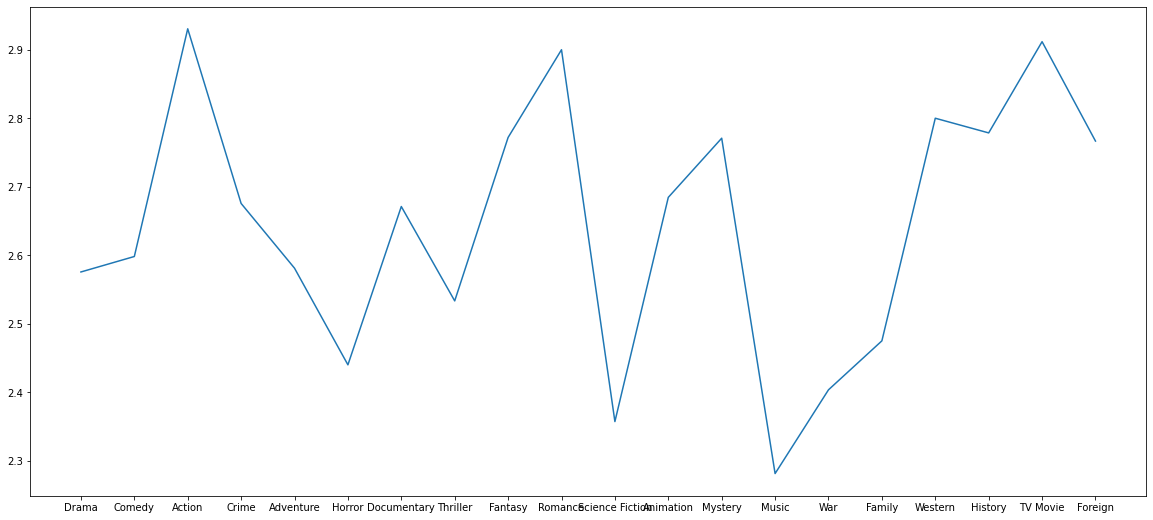

In [41]:
plt.figure(figsize=(20,9))

plt.plot(df_H3.unique_values,df_H3.vote)

# Grafici

<AxesSubplot:xlabel='unique_values', ylabel='Percentage'>

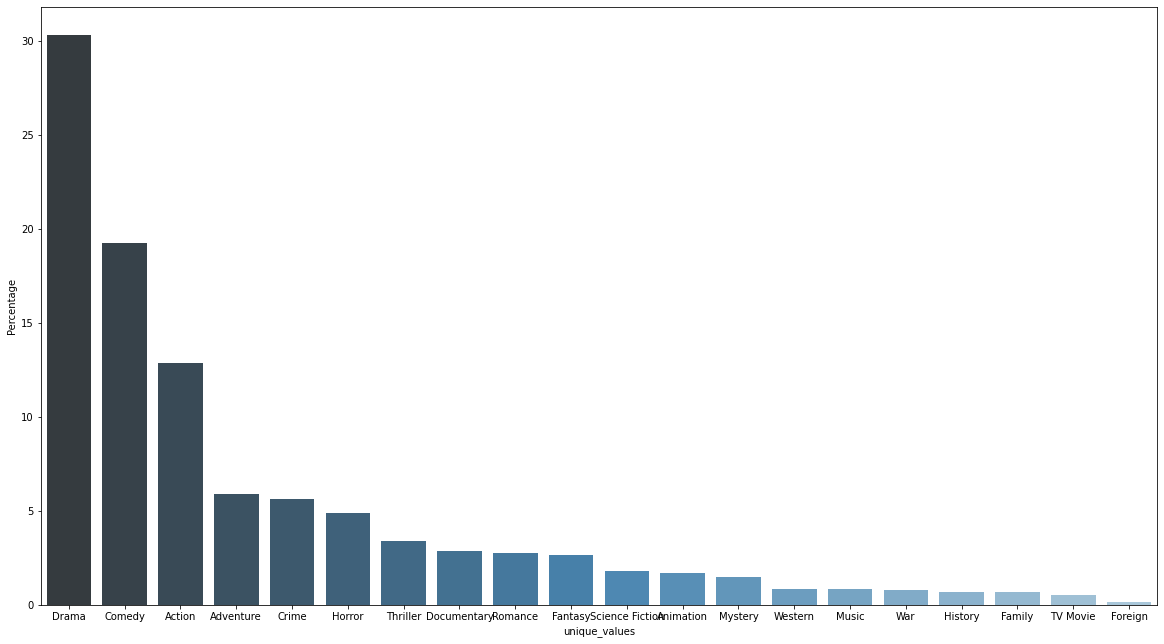

In [42]:
fig = plt.figure(figsize=(20,11))
sns.barplot(y="Percentage", x="unique_values",data = df_H1, palette="Blues_d")


<AxesSubplot:xlabel='unique_values', ylabel='Percentage'>

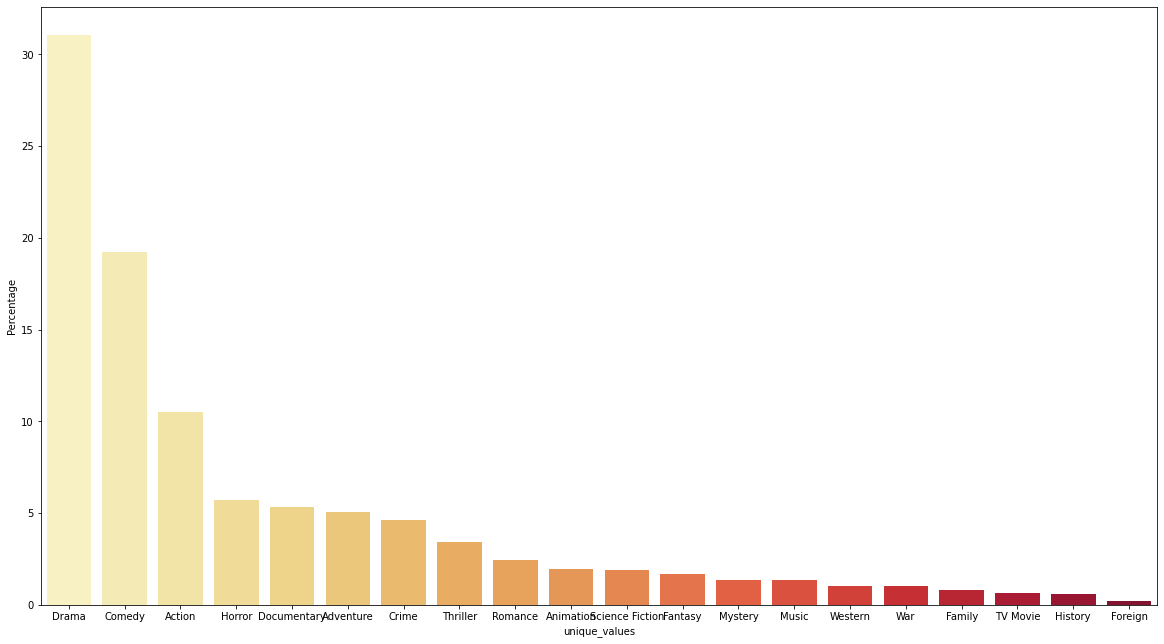

In [43]:
fig = plt.figure(figsize=(20,11))
sns.barplot(y="Percentage", x="unique_values",data = df_H2, palette="YlOrRd")


<AxesSubplot:xlabel='unique_values', ylabel='Percentage'>

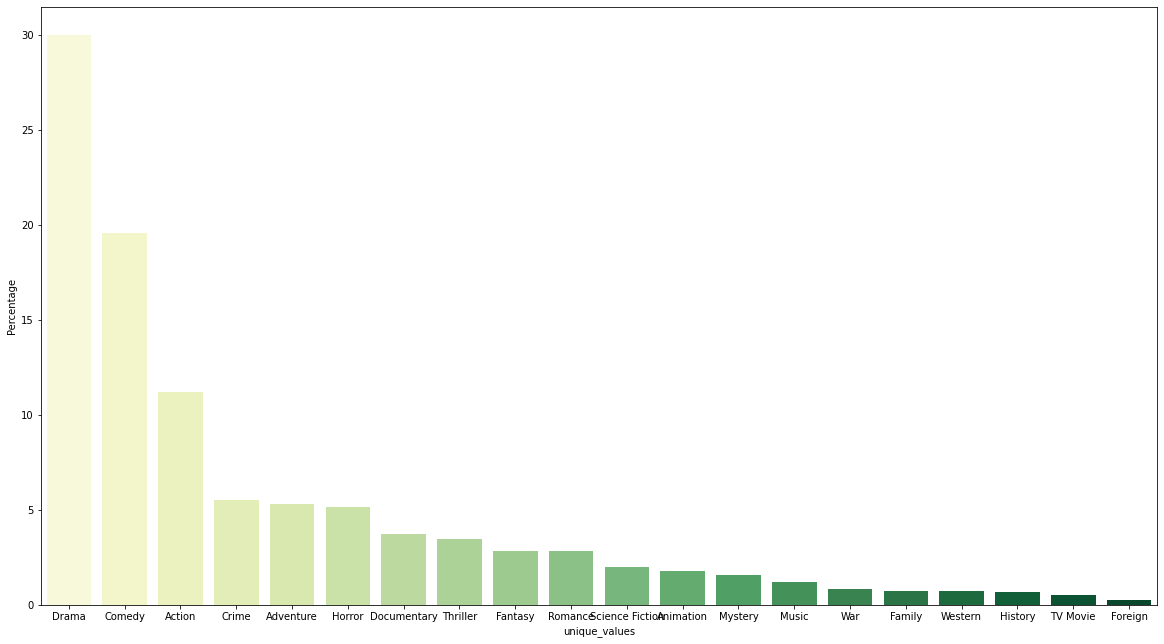

In [44]:
fig = plt.figure(figsize=(20,11))
sns.barplot(y="Percentage", x="unique_values",data = df_H3, palette="YlGn")


In [45]:
#vedere grafici distplot per capire se forse ha votato più drama perché li piace di più? e vedere se c'è correlazione tra il fatto di scegliere lo stesso genere e il voto,
#magari vota drama perchè li piace molto e quindi alla fine avrà un valore medio abbastanza alto